# Very Simple Recurrent Neural Network

This network can be used to demonstrate how to implement the backprop algorithm in a Recurrent Neural Network (RNN).

This notebook represents the code associated with the writeup on [my blog](LINK).

The structure of the network is **many-to-one** as described in C. Olah's [blog](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

The network has:
1. an input layer
2. an arbitrary number of recurrent, fully connected sigmoid layers
3. an output layer.

The purpose of the network is to predict the last element of a sequence.

In [1]:
import numpy as np
import sys
print(sys.version_info)
print(np.__version__)

sys.version_info(major=3, minor=6, micro=1, releaselevel='final', serial=0)
1.12.1


## General structure

I am going to define a the network at the layer-level.
This means that there will be a python class for each layer.

Each layer must contain at least:
1. knowledge of how many neurons it has (`N`);
2. knowledge of how many neurons were in the previous layer (`Nprev`);
2. knowledge of how far back in time the network should unrolled (`unroll_fac`);
2. a matrix of hidden states of size `N`-by-`unroll_fac+1`, where the $t^{th}$ row represents the activation at time $t-1$ (`h`);
2. a matrix `W` of weights, of size `N`-by-`Nprev`;
2. a matrix `Whh` of recurrent weights, of size `N`-by-`N`;
2. a vector `b` of biases, of size `N`;
3. a forward method that takes a vector of size `Nprev` as input, and the returns the vector of activations of size `N`;
3. a backward method that computes the error signal.

### Recurrent Input layer

The input layer takes a vector of size `n`, and outputs the exact same vector, but also stores it in an internal history.
As of right now, this is not the most useful of layers.
But in principle one could benefit from this infrastructure to implement some pre-processing (e.g. creating new features).

In [2]:
class RecurrentInputLayer():
    """Designed to be compatible with Recurrent layers"""
    def __init__(self, n=2, max_back_t_steps=1):
        self.N = n
        self.max_back_t_steps_ = max_back_t_steps
        self.h = np.zeros(shape=(n,self.max_back_t_steps_+1))
    def forward(self, x, tt):
        # hack to allow inference on longer sequences
        if tt >= self.max_back_t_steps_:
            tt = tt % ( self.max_back_t_steps_ - 1)
            
        self.h[:,tt+1] = np.array(x).reshape(self.N, 1)
        return self.h[:,tt+1]

### Sigmoid Layer

all the *hidden* layers of this network are going to be of this type.
The activation function is the sigmoid, defined by

$ \sigma(z) = \frac{1}{1 + e^{-z}} $

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

#### forward pass:

Since we are using the formulation that includes both weights and biases, this is how the forward activation of the layer will be computed:

1. for every timestep $n = 1, \dots,  N$:
  - for every layer $l = 1, \dots, L$:
    - compute the weighted input
$$ \mathbf{z}_l^n = W_l \mathbf{h}_{l-1}^n + W_{hh} \mathbf{h}_{l}^{n-1} + b_l^n $$
    - compute the activation
$$ \mathbf{h}_l^n = \mathbf{\sigma} ( \mathbf{z}_l^n ) $$

#### backward pass:

The backprop algorithm for RNN requires two error signals: $\sideset{_S}{^n_l}\delta$ in *space* (layers) and $\sideset{_T}{^n_l}\delta$ in *time*.

In the **many-to-one** architecture, the error on the cost function is evaluated only **once** at the very end of the feedforward pass.
The backprop algorithm can then be written as:

1. compute the gradient of the cost function, evaluated on the activations of the last layer at the last timestep;
2. set the *error signal*
$$ \sideset{_C}{}\delta = \nabla C \Bigg|_{\mathbf{h_L^N}} $$
3. for each layer $ l $ going backwards:
  - for each time step $n$ going backwards:
    - compute the total error signal
$$ \delta_l^n = \sideset{_S}{^n_{l+1}}\delta + \sideset{_T}{^{n+1}_l}\delta $$
    - compute updates to the weight matrix
$$ \Delta W_l = \Delta W_l + \left ( \delta \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}^n} \right ) \otimes \mathbf{h}_{l-1}^n  $$
    - compute updates to the recurrent weight matrix
$$ \Delta W_{hh} = \Delta W_{hh} + \left ( \delta \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}^n} \right ) \otimes \mathbf{h}_{l}^{n-1}  $$
    - compute updates to the biases
$$ \Delta \mathbf{b}_l = \Delta \mathbf{b}_l - \eta \left ( \delta \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}^n} \right ) $$
    - backpropagate the space error signal
$$ \sideset{_S}{^n_{l}}\delta = W_l^T \left ( \delta \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}^n} \right ) $$
    - backpropagate the time error signal
$$ \sideset{_T}{^n_{l}}\delta = W_{hh}^T \left ( \delta \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}^n} \right ) $$


The `backward` method of the layer has three responsibilities:
- compute the update factor
$$ \left (  \left ( \sideset{_S}{^n_{l+1}}\delta + \sideset{_T}{^{n+1}_l}\delta \right ) \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $$
- compute the space error signal to be backpropagated
$$ \sideset{_S}{^n_{l}}\delta = W_l^T \left ( \left ( \sideset{_S}{^n_{l+1}}\delta + \sideset{_T}{^{n+1}_l}\delta \right ) \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $$
- compute the time error signal to be backpropagated
$$ \sideset{_T}{^n_{l}}\delta = W_{hh}^T \left ( \left ( \sideset{_S}{^n_{l+1}}\delta + \sideset{_T}{^{n+1}_l}\delta \right ) \odot \frac{ d \sigma }{dz} \Bigg|_{\mathbf{z}_{l}} \right ) $$

Remember, the update factor for layer $l$ has size $N_l$, whereas the space error signal has size $N_{l-1}$ and the time error signal has size $N_l$.

###### important note

Troughout this notebook I am going to use the fact that

$ \frac{d\sigma}{dz} \Big|_{z_0} = \sigma(z_0)( 1 - \sigma(z_0) ) $

In [4]:
class RecurrentSigmoidLayer():
    def __init__(self, n=5, nprev=5, max_seq_len=1):
        self.N = n
        self.Nprev = nprev
        self.max_seq_len_ = max_seq_len
        
        self.h = np.random.uniform(low=0., high=1., size=(self.N,self.max_seq_len_+1))
        
        self.b = np.random.uniform(low=0., high=1., size=(self.N,1))
        self.bupdates = np.zeros_like(self.b)
        
        # W represents the matrix of weights from the PREVIOUS layer to THIS layer
        self.W = np.random.uniform(low=0., high=1., size=(self.N,self.Nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.Whh = np.random.uniform(low=0., high=1., size=(self.N,self.N))
        self.Whhupdates = np.zeros_like(self.Whh)
        
    def forward(self, x, tt):
        
        # hack to allow inference on longer sequences
        if tt >= self.max_seq_len_:
            tt = tt % ( self.max_seq_len_ - 1)
        
        x = np.array([x])
        x = x.reshape(self.Nprev, 1)
        
        z = self.W @ x + self.Whh @ self.h[:,tt].reshape(self.N,1) + self.b       
        
        self.h[:,tt+1] = sigmoid(z).reshape(self.N,)     
   
        return self.h[:,tt+1]
    
    def backward(self, Sdelta, Tdelta, tt):

        delta = Sdelta + Tdelta

        h = self.h[:,tt+1].reshape(self.N,1)
        
        update_fac = delta * h * (1. - h)

        new_Sdelta = self.W.T @ update_fac

        new_Tdelta = self.Whh.T @ update_fac  

        return update_fac, new_Sdelta, new_Tdelta


    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.Whh -= self.Whhupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)        
        self.Whhupdates = np.zeros_like(self.Whh)

### Output layer

is a bit more complicated than the input layer.
First of all, the output layer has knowledge of the cost function. 
Additionally, the `backward` method takes the *true label* as input.

Moreover, since our method will be required to predict arbitrary numbers (see below where we generate the data), we use a simple *linear* activation function to avoid clipping output results to a given value.

### Cost function

We are going to use [least-squares](https://en.wikipedia.org/wiki/Least_squares), a popular cost function.

For a single datapoint, if we define $y$ as the true label (which can take any real value) and $p$ as the predicted value by our model, we have the cost function defined by

$ (p - y)^2 $

In [5]:
class MeanSquareError():
        
    def error(self, a, y):
        return (a-y)**2
    
    def derror(self,a, y):
        return 2*(a-y)

In [6]:
class ManyToOneOutputLayer():
    def __init__(self, n=1, nprev=5, cost=MeanSquareError() ):
        self.N = n
        self.Nprev = nprev
        
        self.h = np.zeros(shape=(self.N,1))
        
        self.b = np.random.uniform(low=0., high=1., size=(self.N,1))
        self.bupdates = np.zeros_like(self.b)
        
        self.W = np.random.uniform(low=0., high=1., size=(self.N,self.Nprev))
        self.Wupdates = np.zeros_like(self.W)
        
        self.cost_ = cost
        
    def forward(self, x, tt=0):
        x = np.array([x])
        x = x.reshape(self.Nprev,1)        
        
        self.h = (self.W @ x).reshape(self.N,1) + self.b

        return self.h
    
    def backward(self, y):
        update_fac = self.cost_.derror(self.h,y)
        new_delta = self.W.T @ update_fac

        return update_fac, new_delta      
    
    def update(self):
        self.b -= self.bupdates
        self.W -= self.Wupdates
        self.bupdates = np.zeros_like(self.b)
        self.Wupdates = np.zeros_like(self.W)

## Generate some fake sequence data

In [7]:
import matplotlib.pyplot as plt
% matplotlib inline

#### Sum of binary sequence

The fake data we are going to generate has the following structure: a sequence of 1's and 0's, plus a last value that represents the sum of all the values in the sequence.

An example of a sequence with 5 points would be

$$ 1, 0, 1, 1, 3 $$

To demonstrate the ability to handle sequences with different lengths, we can can generate sequences with random lengths.

In [8]:
def make_sum(n_samples=600, n_discr_points=5):
    Y = np.random.randint(low=0,high=2,size=(n_samples,n_discr_points-1))
    Y = np.c_[Y, np.sum(Y, axis=1)]
    return Y

In [9]:
def make_simpler(n_samples=600, n_discr_points=5):
    Y = np.random.randint(low=0,high=2,size=(n_samples,n_discr_points-1))
    Y = np.c_[Y, Y[:,-1]]
    return Y

In [10]:
def make_sum_different_lengths(n_samples=600, min_n_discr_points=4, max_n_discr_points=6):
    Y = list()
    for n in range(n_samples):
        n_discr_points = np.random.randint(low=min_n_discr_points, high=max_n_discr_points+1)
        y = np.random.randint(low=0,high=2,size=(1,n_discr_points-1))
        y = np.c_[y, np.sum(y, axis=1)]
        Y.append(y)
    return Y

In [11]:
n_samples = 600
min_n_discr_points = 6
max_n_discr_points = 9
y = make_sum_different_lengths(n_samples, min_n_discr_points, max_n_discr_points)
print (len(y))
print(y[:5])

600
[array([[1, 1, 0, 0, 1, 0, 0, 3]]), array([[1, 0, 0, 0, 1, 0, 1, 3]]), array([[1, 1, 1, 1, 1, 1, 1, 0, 7]]), array([[0, 1, 0, 0, 1, 2]]), array([[1, 0, 1, 1, 0, 0, 0, 3]])]


## Instantiate a network

In [26]:
n_hidden_neurons = [6,4]
n_hidden_layers = len(n_hidden_neurons)
nlayers = n_hidden_layers+2

In [27]:
max_len_seq = max_n_discr_points
#TBTTP_max_back_steps = max_n_discr_points
TBTTP_max_back_steps = max_n_discr_points-2

In [28]:
CostFunction = MeanSquareError()

In [29]:
layers = []
layers.append( RecurrentInputLayer(1,max_len_seq) )
nprev = 1
for n in n_hidden_neurons:
    layers.append(RecurrentSigmoidLayer(n, nprev, max_len_seq))
    nprev = n
layers.append(ManyToOneOutputLayer(1,nprev,CostFunction))

## Train and validate

A common practice is to split the dataset in training and validation.
This is done to try to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In [30]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split( y, test_size=0.33, random_state=42 )
print(len(y_train))
print(len(y_test))


402
198


In [31]:
eta = 0.1
n_epochs = 500

training_error = []
validation_error = []
    
for i in range(n_epochs):

    errors = []
    for idx, data_sample in enumerate(y_train):
        
        num_t_steps = data_sample.shape[1]
        
        # feedforward
        for t in range(num_t_steps):
            a = data_sample[:,t]
            for i in range(0,nlayers):
                a = layers[i].forward(a,t)

        # now a holds the prediction for the next value
        # the true next value is data_sample[num_t_steps]
        errors.append(CostFunction.error(a, data_sample[:,num_t_steps-1]))
    
        ###########################################
        # backprop through time
        
        num_TBPTT_steps = min( TBTTP_max_back_steps, num_t_steps)
        
        # output layer: no time        
        update_fac, delta = layers[nlayers-1].backward(data_sample[:,num_t_steps-1])     
        layers[nlayers-1].Wupdates = eta*np.outer(update_fac, layers[nlayers-2].h[:,num_t_steps-1] )
        layers[nlayers-1].bupdates = eta*update_fac   
        
        # Sdelta_dict[l][t] is the error signal that layer l passes to layer (l-1) at time t
        # Tdelta_dict[l][t] is the error signal that layer l passes to itself from time t to t-1
        Sdelta_dict = dict()
        Tdelta_dict = dict()
        for l in range(nlayers-1,0,-1):
            Sdelta_dict[l] = dict()
            Tdelta_dict[l] = dict()
            for t in range(num_t_steps,-1,-1):
                Sdelta_dict[l][t] = np.zeros( shape=(layers[l].Nprev,1) )
                Tdelta_dict[l][t] = np.zeros( shape=(layers[l].N,1) )

        Sdelta_dict[nlayers-1][num_t_steps-1] = delta.reshape(layers[nlayers-1].Nprev,1)
        
        # recurrent layers
        for l in range(nlayers-2,0,-1):
            for t in range(num_t_steps-1,num_t_steps-num_TBPTT_steps-1,-1):
                update_fac, Sdelta, Tdelta = layers[l].backward(Sdelta_dict[l+1][t], Tdelta_dict[l][t+1], t)
                Sdelta_dict[l][t] = Sdelta
                Tdelta_dict[l][t] = Tdelta
                layers[l].Wupdates   += eta*np.outer(update_fac, layers[l-1].h[:,t+1] )
                layers[l].Whhupdates += eta*np.outer(update_fac, layers[l].h[:,t] )
                layers[l].bupdates   += eta*update_fac
                   
        for i in range(1,nlayers):
            layers[i].update()
            
    training_error.append(np.mean(errors))
    
    # validation
    errors = []
    for idx, data_sample in enumerate(y_test):                
        num_t_steps = data_sample.shape[1]
        # feedforward
        for t in range(num_t_steps):
            a = data_sample[:,t]
            for i in range(0,nlayers):
                a = layers[i].forward(a,t)
        errors.append(CostFunction.error(a, data_sample[:,num_t_steps-1]))
    validation_error.append(np.mean(errors))

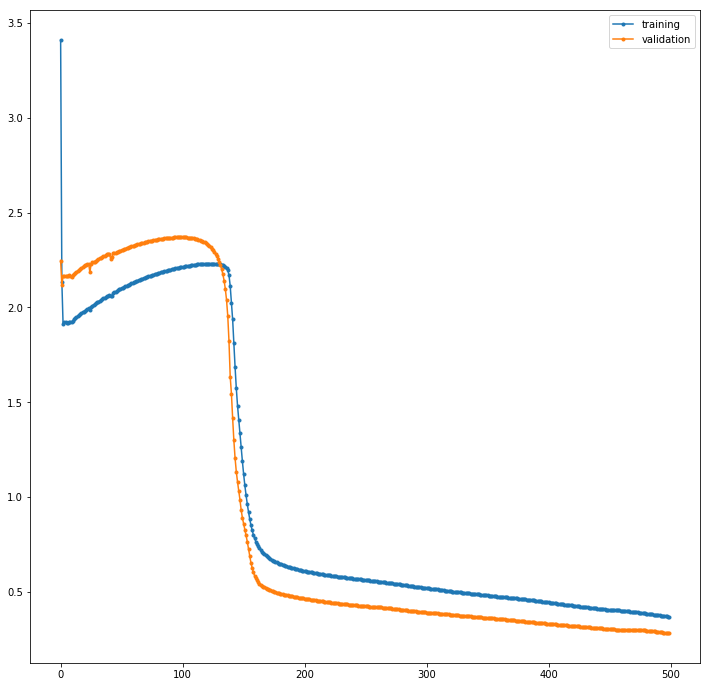

In [32]:
plt.figure(figsize=(12,12))
plt.plot(range(n_epochs), training_error, '.-')
plt.plot(range(n_epochs), validation_error, '.-')
plt.legend(['training','validation'])

## Inference time

Let's do some inference!
This means trying to predict the class of new data points.

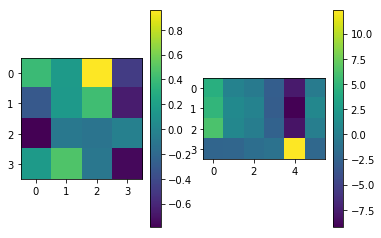

In [33]:
plt.subplot(1,2,1)
plt.imshow(layers[-2].Whh)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(layers[-2].W)
plt.colorbar()

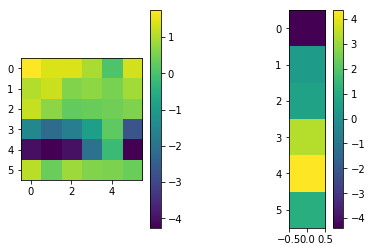

In [34]:
plt.subplot(1,2,1)
plt.imshow(layers[-3].Whh)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(layers[-3].W)
plt.colorbar()

In [35]:
def inference(layers, data_sample):
        num_t_steps = data_sample.shape[1]
        
        # feedforward
        for t in range(num_t_steps):
            a = data_sample[:,t]
            for i in range(0,nlayers):
                a = layers[i].forward(a,t)
        return a

In [36]:
for i in range(15):
    print(y_test[i])
    print(inference(layers,y_test[i]))

[[1 1 0 0 0 1 1 0 4]]
[[ 4.04551953]]
[[1 0 1 0 1 3]]
[[ 3.07783323]]
[[1 0 0 0 0 1]]
[[ 1.57898966]]
[[1 1 0 1 0 0 3]]
[[ 3.08386173]]
[[1 1 1 1 1 0 5]]
[[ 4.69309229]]
[[0 0 0 0 1 1 0 1 3]]
[[ 3.07782944]]
[[1 0 1 0 0 1 1 4]]
[[ 4.04687905]]
[[1 1 1 1 1 5]]
[[ 4.69311691]]
[[1 1 1 0 1 0 0 4]]
[[ 4.04458022]]
[[1 0 1 0 1 0 0 3]]
[[ 3.08386135]]
[[0 1 0 0 0 1 1 0 3]]
[[ 3.08498737]]
[[0 0 0 1 1 1 0 0 3]]
[[ 3.08386318]]
[[0 0 1 0 0 1]]
[[ 1.57898974]]
[[0 0 1 0 0 0 0 0 1]]
[[ 1.57898966]]
[[1 1 0 0 1 0 0 3]]
[[ 3.08386122]]


#### Inference on completely new datapoint

In [37]:
arbitrary_Y = make_sum_different_lengths(1, min_n_discr_points, max_n_discr_points)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y[0]))

[array([[0, 1, 1, 1, 0, 3]])]
[[ 3.08499716]]


#### Inference on very short  sequences

should always get it right

In [38]:
arbitrary_Y = make_sum_different_lengths(1, min_n_discr_points-2, min_n_discr_points-2)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y[0]))

[array([[0, 1, 1, 2]])]
[[ 1.92320306]]


#### Inference on very long  sequences

doesn't always get it right

In [42]:
arbitrary_Y = make_sum_different_lengths(1, max_n_discr_points+3, max_n_discr_points+3)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y[0]))
arbitrary_Y = np.array( [1]*(max_n_discr_points+3) + [max_n_discr_points+3] ).reshape(1,max_n_discr_points+3+1)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y))
arbitrary_Y = np.array([0]*4 +  [1]*(max_n_discr_points-1) +  [max_n_discr_points-1] ).reshape(1,max_n_discr_points+3+1)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y))
arbitrary_Y = np.array( [1]*3  + [0]*(max_n_discr_points) +  [3] ).reshape(1,max_n_discr_points+3+1)
print(arbitrary_Y)
print(inference(layers, arbitrary_Y))

[array([[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 6]])]
[[ 4.69406188]]
[[ 1  1  1  1  1  1  1  1  1  1  1  1 12]]
[[ 4.69406779]]
[[0 0 0 0 1 1 1 1 1 1 1 1 8]]
[[ 4.6940678]]
[[1 1 1 0 0 0 0 0 0 0 0 0 3]]
[[ 3.08386295]]
